In [2]:
# https://zhuanlan.zhihu.com/p/66898788?s_r=0

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert

In [7]:
# 字体设置
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
plt.rcParams['font.family'] = 'sans-serif'  # 英文字体
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

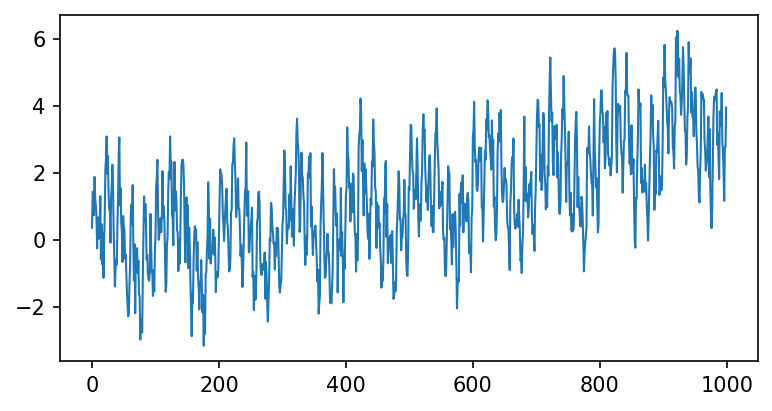

In [6]:
# 原始信号

T = 1000
fs = 1./T
t = np.linspace(0, 1, T,endpoint=True)
f_1 = 10
f_2 = 50
f_3 = 100
mode_1 = (2 * t) ** 2
mode_2 = np.sin(2 * np.pi * f_1 * t)
mode_3 = np.sin(2 * np.pi * f_2 * t)
mode_4 = np.sin(2 * np.pi * f_3 * t)
f = mode_1 + mode_2 + mode_3 + mode_4 + 0.5 * np.random.randn(1000)

plt.figure(figsize=(6,3), dpi=150)
plt.plot(f, linewidth=1)

In [10]:
class VMD:
    def __init__(self, K, alpha, tau, tol=1e-7, maxIters=200, eps=1e-9):
        """
        :param K: 模态数
        :param alpha: 每个模态初始中心约束强度
        :param tau: 对偶项的梯度下降学习率
        :param tol: 终止阈值
        :param maxIters: 最大迭代次数
        :param eps: eps
        """
        self.K =K
        self.alpha = alpha
        self.tau = tau
        self.tol = tol
        self.maxIters = maxIters
        self.eps = eps

    def __call__(self, f):
        T = f.shape[0]
        t = np.linspace(1, T, T) / T
        omega = t - 1. / T
        # 转换为解析信号
        f = hilbert(f)
        f_hat = np.fft.fft(f)
        u_hat = np.zeros((self.K, T), dtype=complex)
        omega_K = np.zeros((self.K,))
        lambda_hat = np.zeros((T,), dtype=complex)
        # 用以判断
        u_hat_pre = np.zeros((self.K, T), dtype=complex)
        u_D = self.tol + self.eps

        # 迭代
        n = 0
        while n < self.maxIters and u_D > self.tol:
            for k in range(self.K):
                # u_hat
                sum_u_hat = np.sum(u_hat, axis=0) - u_hat[k, :]
                res = f_hat - sum_u_hat
                u_hat[k, :] = (res + lambda_hat / 2) / (1 + self.alpha * (omega - omega_K[k]) ** 2)

                # omega
                u_hat_k_2 = np.abs(u_hat[k, :]) ** 2
                omega_K[k] = np.sum(omega * u_hat_k_2) / np.sum(u_hat_k_2)

            # lambda_hat
            sum_u_hat = np.sum(u_hat, axis=0)
            res = f_hat - sum_u_hat
            lambda_hat -= self.tau * res

            n += 1
            u_D = np.sum(np.abs(u_hat - u_hat_pre) ** 2)
            u_hat_pre[::] = u_hat[::]

        # 重构，反傅立叶之后取实部
        u = np.real(np.fft.ifft(u_hat, axis=-1))

        omega_K = omega_K * T
        idx = np.argsort(omega_K)
        omega_K = omega_K[idx]
        u = u[idx, :]
        return u, omega_K

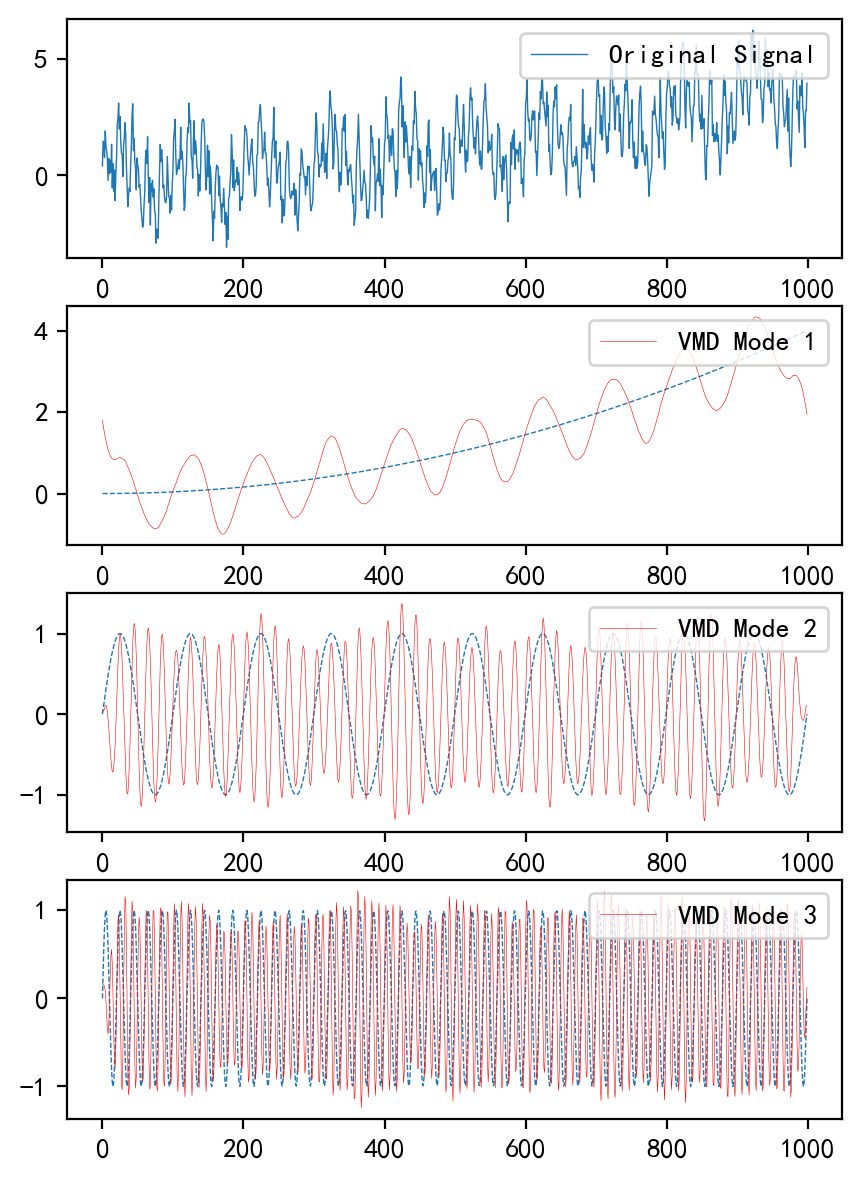

In [32]:
K = 3
alpha = 2000
tau = 1e-6
vmd = VMD(K, alpha, tau)
u, omega_K = vmd(f)
omega_K
# array([0.85049797, 10.08516203, 50.0835613, 100.13259275]))
plt.figure(figsize=(5,9), dpi=200)

plt.subplot(5,1,1)
plt.plot(f, linewidth=0.5,label='Original Signal')
plt.legend(loc='upper right')

plt.subplot(5,1,2)
plt.plot(mode_1, linewidth=0.5, linestyle='--')
plt.plot(u[0,:], linewidth=0.2, c='r',label='VMD Mode 1')
plt.legend(loc='upper right')


plt.subplot(5,1,3)
plt.plot(mode_2, linewidth=0.5, linestyle='--')
plt.plot(u[1,:], linewidth=0.2, c='r',label='VMD Mode 2')
plt.legend(loc='upper right')

plt.subplot(5,1,4)
plt.plot(mode_3, linewidth=0.5, linestyle='--')
plt.plot(u[2,:], linewidth=0.2, c='r',label='VMD Mode 3')
plt.legend(loc='upper right')

#plt.subplot(5,1,5)
#plt.plot(mode_4, linewidth=0.5, linestyle='--')
#plt.plot(u[3,:], linewidth=0.2, c='r',label='VMD Mode 4')

plt.legend(loc='upper right')